In [6]:
!pip install --quiet pdf2image
!apt-get install -y poppler-utils
!pip install --quiet fpdf

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


CNN trained on the EMNIST letters dataset
Used to compare similar traits written character

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6065 - loss: 1.2980 - val_accuracy: 0.9229 - val_loss: 0.2335
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9027 - loss: 0.2979 - val_accuracy: 0.9383 - val_loss: 0.1987
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9216 - loss: 0.2353 - val_accuracy: 0.9435 - val_loss: 0.1807
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9286 - loss: 0.2074 - val_accuracy: 0.9438 - val_loss: 0.1742
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9357 - loss: 0.1885 - val_accuracy: 0.9436 - val_loss: 0.1853
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9385 - loss: 0.1770 - val_accuracy: 0.9447 - val_loss: 0.1734
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9403 - loss: 0.1690 - val_accuracy: 0.9472 - val_loss: 0.1752
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9441 - loss: 0.1568 - val_accu

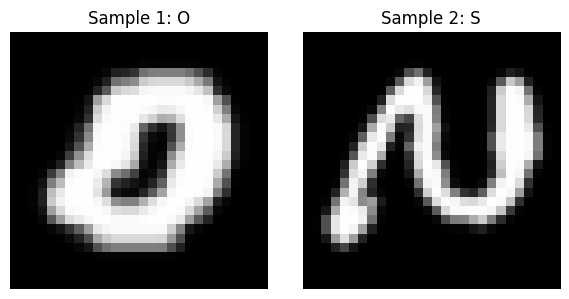

Similarity score between chosen samples: 0.2633


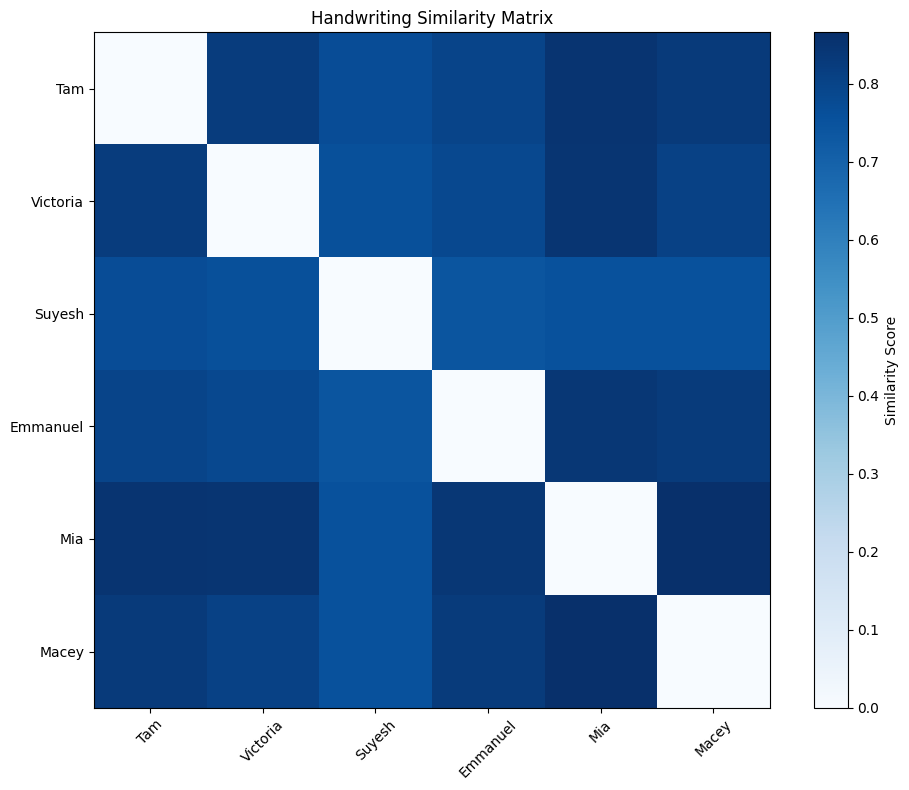


Detailed Comparison Results:

Tam's writing compared to:
  Victoria: 0.824
  Suyesh: 0.769
  Emmanuel: 0.796
  Mia: 0.852
  Macey: 0.830

Victoria's writing compared to:
  Tam: 0.824
  Suyesh: 0.759
  Emmanuel: 0.784
  Mia: 0.846
  Macey: 0.808

Suyesh's writing compared to:
  Tam: 0.769
  Victoria: 0.759
  Emmanuel: 0.742
  Mia: 0.756
  Macey: 0.755

Emmanuel's writing compared to:
  Tam: 0.796
  Victoria: 0.784
  Suyesh: 0.742
  Mia: 0.841
  Macey: 0.827

Mia's writing compared to:
  Tam: 0.852
  Victoria: 0.846
  Suyesh: 0.756
  Emmanuel: 0.841
  Macey: 0.866

Macey's writing compared to:
  Tam: 0.830
  Victoria: 0.808
  Suyesh: 0.755
  Emmanuel: 0.827
  Mia: 0.866


In [8]:
np.random.seed(40)
tf.random.set_seed(62)

def load_data():
    train_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
    X_train = train_data.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    
    test_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values
    
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    return X_train, y_train, X_test, y_test


def create_model():
    input_shape = (28, 28, 1)
    
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='forensic_dense')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(26, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


def extract_forensic_features(model, image_batch):
    feature_model = Model(inputs=model.input, outputs=model.get_layer('forensic_dense').output)
    features = feature_model.predict(image_batch, verbose=0)
    return features


def compare_characters(model, char1, char2):
    feat1 = extract_forensic_features(model, char1.reshape(1, 28, 28, 1))
    feat2 = extract_forensic_features(model, char2.reshape(1, 28, 28, 1))
    
    similarity = np.dot(feat1, feat2.T) / (np.linalg.norm(feat1) * np.linalg.norm(feat2))
    return similarity[0][0]


def analyze_character_features(model, character):
    features = extract_forensic_features(model, character.reshape(1, 28, 28, 1))
    feature_stats = {
        'mean': np.mean(features),
        'std': np.std(features),
        'max': np.max(features),
        'min': np.min(features)
    }
    return feature_stats


def batch_compare_characters(model, reference_char, comparison_chars):
    similarities = []
    for char in comparison_chars:
        sim = compare_characters(model, reference_char, char)
        similarities.append(sim)
    return np.array(similarities)


def main():
    X_train, y_train, X_test, y_test = load_data()
    y_train = y_train - 1
    y_test = y_test - 1
    
    model = create_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=128, 
        epochs=10, 
        validation_split=0.1, 
        verbose=1
    )
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    idx1, idx2 = np.random.randint(0, len(X_test), 2)
    similarity = compare_characters(model, X_test[idx1], X_test[idx2])
    
  
    plt.figure(figsize=(6,3))
    
    plt.subplot(1,2,1)
    plt.imshow(X_test[idx1].reshape(28, 28), cmap='gray')
    plt.title(f"Sample 1: {chr(65 + y_test[idx1])}")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(X_test[idx2].reshape(28, 28), cmap='gray')
    plt.title(f"Sample 2: {chr(65 + y_test[idx2])}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Similarity score between chosen samples: {similarity:.4f}")
    
    return model, history, X_test, y_test


def extract_images_from_pdf(pdf_path, output_dir=None):
    try:
        images = convert_from_path(pdf_path)
        
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            saved_paths = []
            
            for i, image in enumerate(images):
                image_path = os.path.join(output_dir, f'page_{i+1}.png')
                image.save(image_path, 'PNG')
                
                saved_paths.append(image_path)
            
            return saved_paths
        
        return images
        
    except Exception as e:
        print(f"Error processing PDF {pdf_path}: {str(e)}")
        return []


def process_writer_pdfs(base_dir):
    writer_samples = {}
    
    for writer_name in os.listdir(base_dir):
        writer_path = os.path.join(base_dir, writer_name)
        
        if os.path.isdir(writer_path):
            writer_samples[writer_name] = []
            
            for file_name in os.listdir(writer_path):
                if file_name.lower().endswith('.pdf'):
                    pdf_path = os.path.join(writer_path, file_name)
                    images = extract_images_from_pdf(pdf_path)
                    
                    for img in images:
                        img_gray = img.convert('L')
                        img_array = np.array(img_gray)
                        
                        img_resized = cv2.resize(img_array, (28, 28))
                        img_processed = img_resized.astype('float32') / 255.0
                        img_processed = img_processed.reshape(1, 28, 28, 1)
                        
                        writer_samples[writer_name].append(img_processed)
    
    return writer_samples


def compare_writers(model, writer_samples):
    results = {}
    
    for writer1 in writer_samples:
        results[writer1] = {}
        
        for writer2 in writer_samples:
            if writer1 != writer2:
                similarities = []
                
                for sample1 in writer_samples[writer1]:
                    for sample2 in writer_samples[writer2]:
                        similarity = compare_characters(model, sample1[0], sample2[0])
                        similarities.append(similarity)
                
                avg_similarity = np.mean(similarities) if similarities else 0
                results[writer1][writer2] = avg_similarity
    
    return results


def visualize_comparison_results(results):
    writers = list(results.keys())
    similarity_matrix = np.zeros((len(writers), len(writers)))
    
    for i, writer1 in enumerate(writers):
        for j, writer2 in enumerate(writers):
            if writer1 != writer2:
                similarity_matrix[i, j] = results[writer1][writer2]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='Blues')
    plt.colorbar(label='Similarity Score')
    plt.xticks(range(len(writers)), writers, rotation=45)
    plt.yticks(range(len(writers)), writers)
    plt.title('Handwriting Similarity Matrix')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    model, history, X_test, y_test = main()
    
    base_dir = "/kaggle/input/personalprofile"
    writer_samples = process_writer_pdfs(base_dir)
    comparison_results = compare_writers(model, writer_samples)
    
    visualize_comparison_results(comparison_results)
    
    print("\nDetailed Comparison Results:")
    for writer1, comparisons in comparison_results.items():
        
        print(f"\n{writer1}'s writing compared to:")
        for writer2, similarity in comparisons.items():
            print(f"  {writer2}: {similarity:.3f}")


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_split=0.1)
